<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Real-data---20-news-groups" data-toc-modified-id="Real-data---20-news-groups-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Real data - 20 news groups</a></span></li><li><span><a href="#Time-Forest" data-toc-modified-id="Time-Forest-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Time Forest</a></span></li><li><span><a href="#Average-result-for-every-target" data-toc-modified-id="Average-result-for-every-target-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Average result for every target</a></span><ul class="toc-item"><li><span><a href="#Optimize-hyper-params" data-toc-modified-id="Optimize-hyper-params-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Optimize hyper-params</a></span></li><li><span><a href="#Plot-benchmark-Vs-challenger:" data-toc-modified-id="Plot-benchmark-Vs-challenger:-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Plot benchmark Vs challenger:</a></span></li><li><span><a href="#Domain-Classifier" data-toc-modified-id="Domain-Classifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Domain Classifier</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pdb
import warnings
import seaborn as sns
import os
import glob
import sys

from sklearn import metrics
from time import time
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from time_robust_forest.hyper_opt import env_wise_hyper_opt
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm_notebook
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')

In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

In [4]:
np.random.seed(42)

## Real data - 20 news groups

In [5]:
MAX_VOCABULARY = 100
TARGET = 1
PREFIX = "20news"

In [6]:
train = fetch_20newsgroups(subset="train") 
test = fetch_20newsgroups(subset="test")

del test["DESCR"]
del train["DESCR"]

in_time = pd.DataFrame.from_dict(train, orient="index").transpose() 

out_of_time = pd.DataFrame.from_dict(test, orient="index").transpose()

In [7]:
in_time.shape

(11314, 4)

In [8]:
in_time["target"].value_counts()

10    600
15    599
8     598
9     597
11    595
13    594
7     594
14    593
5     593
12    591
2     591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
Name: target, dtype: int64

In [9]:
out_of_time["target"].value_counts()

10    399
8     398
15    398
9     397
13    396
7     396
11    396
5     395
2     394
14    394
12    393
3     392
6     390
1     389
4     385
17    376
16    364
0     319
18    310
19    251
Name: target, dtype: int64

In [10]:
in_time.tail()

,data,filenames,target_names,target
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,13
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,4
11311,From: westes@netcom.com (Will Estes)\nSubject:...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,3
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,1
11313,From: gunning@cco.caltech.edu (Kevin J. Gunnin...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,8


In [11]:
out_of_time.shape

(7532, 4)

In [12]:
in_time[pd.isnull(in_time["data"])]

,data,filenames,target_names,target


In [13]:
out_of_time[pd.isnull(out_of_time["data"])]

,data,filenames,target_names,target


In [14]:
def preprocess(data):
    data["data"] = data["data"].apply(lambda x: " ".join(x.split("Lines: ")[1:]))
    
    return data

In [15]:
out_of_time = preprocess(out_of_time)
in_time = preprocess(in_time)

In [16]:
out_of_time["binary_target"] = out_of_time["target"].apply(lambda x: 1 if x == TARGET else 0)
in_time["binary_target"] = in_time["target"].apply(lambda x: 1 if x == TARGET else 0)

In [17]:
time_step = 2840
time_column = "date"
dummy_time_column = "dummy_date"
target = "binary_target"

In [18]:
in_time[time_column] = (in_time.index.values / time_step).astype(int)

<AxesSubplot:>

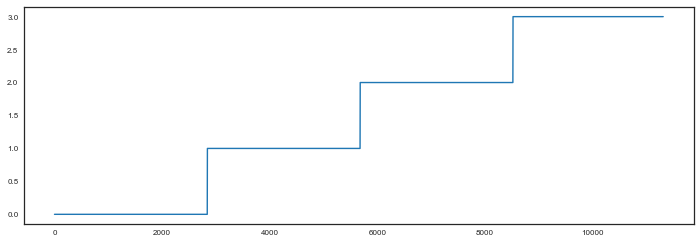

In [19]:
in_time[time_column].plot()

In [20]:
in_time.groupby(time_column).count()

,data,filenames,target_names,target,binary_target
date,,,,,
0,2840,2840,20,2840,2840
1,2840,2840,0,2840,2840
2,2840,2840,0,2840,2840
3,2794,2794,0,2794,2794


<AxesSubplot:>

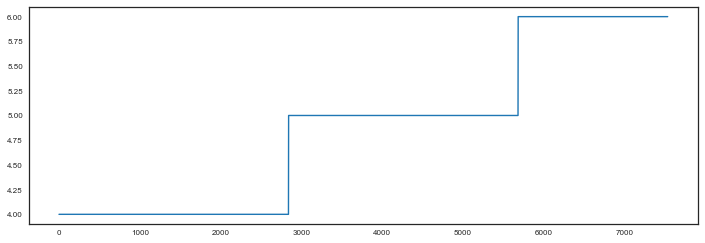

In [21]:
out_of_time[time_column] = ((out_of_time.index.values) / time_step).astype(int) + np.max(in_time.date.values) + 1
out_of_time[time_column].plot()

In [22]:
out_of_time.groupby(time_column).count()

,data,filenames,target_names,target,binary_target
date,,,,,
4,2840,2840,20,2840,2840
5,2840,2840,0,2840,2840
6,1852,1852,0,1852,1852


In [23]:
train, test = train_test_split(in_time, 
                               test_size=0.2, 
                               random_state=42)

In [24]:
vectorizer = TfidfVectorizer(max_features=MAX_VOCABULARY,
                             stop_words="english",
                             binary=False,
                             use_idf=True,
                             norm=False)

train_vectors = pd.DataFrame(vectorizer.fit_transform(train["data"]).toarray(), columns=vectorizer.vocabulary_)
test_vectors = pd.DataFrame(vectorizer.transform(test["data"]).toarray(), columns=vectorizer.vocabulary_)
oot_vectors = pd.DataFrame(vectorizer.transform(out_of_time["data"]).toarray(), columns=vectorizer.vocabulary_)

In [25]:
features = list(vectorizer.vocabulary_.keys())

In [26]:
train.iloc[0]["data"]

"5\n\nNikon FM-2n with 50 mm Nikkor and accessories for sale.I bought this camera in\nHong Kong two years ago and everything has been looked after very well. I'm now\nselling some more gear to finance my next big film project.\n\nAsking $350 for package. NO BARGAINS.\n"

In [27]:
train.head()

,data,filenames,target_names,target,binary_target,date
6606,5\n\nNikon FM-2n with 50 mm Nikkor and accesso...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,6,0,2
10808,"125\n\nHeres the life of St. MAria Goretti, po...",/Users/luis.moneda/scikit_learn_data/20news_ho...,None,15,0,3
10683,90\n\nkwfinken@pooh.harpo.uccs.edu (Kevin W. F...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,15,0,3
2089,18\nNntp-Posting-Host: cat.lv-lib.nevada.edu\n...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,2,0,0
4026,"15\n\nIn article <114152@bu.edu>, lcai@acs2.bu...",/Users/luis.moneda/scikit_learn_data/20news_ho...,None,3,0,1


In [28]:
train_vectors[time_column] = train[time_column].values
test_vectors[time_column] = test[time_column].values
oot_vectors[time_column] = out_of_time[time_column].values

In [29]:
train_vectors[dummy_time_column] = 1

In [30]:
train_vectors

,years,like,set,little,time,day,jesus,god,did,work,...,right,software,state,better,university,things,ax,g9v,date,dummy_date
0,0.0,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.211018,2,1
1,0.0,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,2.995159,0.000000,0.000000,0.000000,9.633054,3,1
2,0.0,0.000000,0.0,0.00000,0.000000,0.00000,3.434918,0.000000,0.000000,0.0,...,0.000000,2.711955,0.000000,2.995159,0.000000,0.000000,0.000000,6.422036,3,1
3,0.0,0.000000,0.0,3.50274,0.000000,3.37853,3.434918,0.000000,3.542663,0.0,...,0.000000,0.000000,7.471432,0.000000,0.000000,1.674975,0.000000,0.000000,0,1
4,0.0,0.000000,0.0,0.00000,0.000000,3.37853,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9046,0.0,3.182203,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,1
9047,0.0,3.182203,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,2.861526,0.000000,0.000000,0.000000,0.000000,6.699899,0.000000,0.000000,1,1
9048,0.0,0.000000,0.0,0.00000,3.535665,0.00000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.674975,0.000000,9.633054,1,1
9049,0.0,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,3.663435,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.674975,0.000000,3.211018,0,1


In [31]:
model = TimeForestClassifier(time_column=dummy_time_column,
                             n_estimators=70,
                             multi=True, 
                             min_sample_periods=15)

model.fit(train_vectors[features + [dummy_time_column]], train[target].values)

In [32]:
train["prediction"] = model.predict_proba(train_vectors)[:, 1]
roc_auc_score(train[target], train["prediction"])

0.8247289795045307

In [33]:
test["prediction"] = model.predict_proba(test_vectors)[:, 1]
roc_auc_score(test[target], test["prediction"])

0.7921491431218156

In [34]:
out_of_time["prediction"] = model.predict_proba(oot_vectors)[:, 1]

benchmark_dt_out_of_time = roc_auc_score(out_of_time[target], out_of_time["prediction"])
benchmark_dt_out_of_time

0.7846247445231045

In [35]:
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction"]))

date
4    0.808604
5    0.756565
6    0.787637
dtype: float64

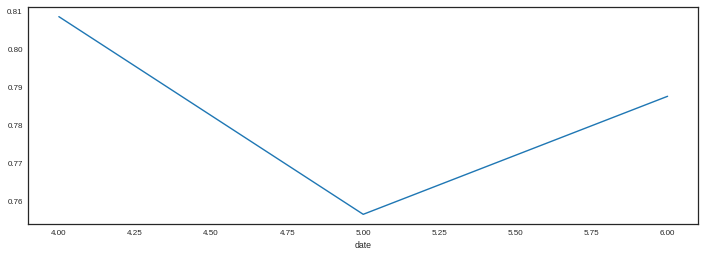

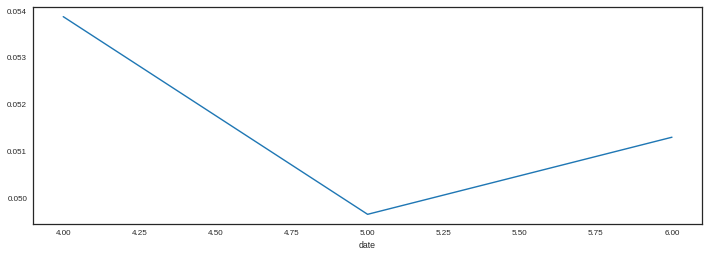

In [36]:
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction"])).plot()
plt.show()
out_of_time.groupby(time_column)[target].mean().plot()
plt.show()

In [37]:
model.feature_importance(impurity_decrease=True).head(10)

,Importance
Feature,
11,0.053468
host,0.032762
data,0.026779
20,0.016503
space,0.010223
things,0.008394
don,0.008113
state,0.007543
say,0.007101


## Time Forest

In [38]:
time_model_tree = TimeForestClassifier(time_column=time_column,
                                       n_estimators=70,
                                       multi=True, 
                                       min_sample_periods=20)

time_model_tree.fit(train_vectors[features + [time_column]], train[target].values)

train["time_prediction_tree"] = time_model_tree.predict_proba(train_vectors)[:, 1]
print(roc_auc_score(train[target], train["time_prediction_tree"]))

test["time_prediction_tree"] = time_model_tree.predict_proba(test_vectors)[:, 1]
print(roc_auc_score(test[target], test["time_prediction_tree"]))

out_of_time["time_prediction_tree"] = time_model_tree.predict_proba(oot_vectors)[:, 1]
print(roc_auc_score(out_of_time[target], out_of_time["time_prediction_tree"]))

0.8002981225450161
0.7879850001781451
0.7769423531837847


In [39]:
time_model_tree.feature_importance(impurity_decrease=True).head(10)

,Importance
Feature,
11,0.056548
host,0.035415
data,0.023616
20,0.014348
things,0.010171
make,0.009063
file,0.008485
space,0.007745
nntp,0.006999


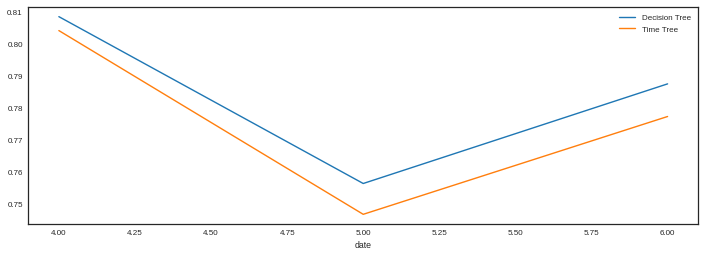

In [40]:
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction"])).plot(label="Decision Tree")
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction_tree"])).plot(label="Time Tree")
plt.legend()
plt.show()

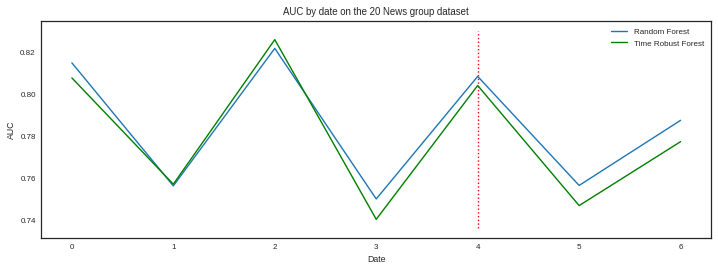

In [41]:
out_of_time_min_date = out_of_time["date"].min()
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction_tree"])).plot(label="Time Robust Forest", color="green")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(out_of_time_min_date, ymin, ymax, linestyle="dotted", color="red")
plt.legend()
plt.title("AUC by date on the 20 News group dataset")
plt.ylabel("AUC")
plt.xlabel("Date")
plt.show()

## Average result for every target

In [40]:
label_dict = in_time.groupby("target_names")["target"].min()
label_dict = {v: k for k, v in label_dict.items()}
label_dict

{7: 'talk.politics.mideast',
 4: 'sci.electronics',
 1: 'talk.politics.guns',
 14: 'sci.med',
 16: 'comp.windows.x',
 13: 'misc.forsale',
 3: 'rec.autos',
 2: 'rec.motorcycles',
 8: 'rec.sport.hockey',
 19: 'sci.crypt',
 6: 'sci.space',
 0: 'soc.religion.christian',
 12: 'talk.politics.misc',
 5: 'talk.religion.misc'}

In [43]:
#from pycaret.classification import *

In [73]:
params_grid = {"n_estimators": [1], 
              "max_depth": [5, 10, 15],
              "min_impurity_decrease": [1e-5, 0],
              "min_sample_periods": [1, 5, 15],
              "max_features": [1.0],
              "period_criterion": ["max", "avg"]}

# params_grid = {"n_estimators": [4], 
#               "max_depth": [5],
#               "min_impurity_decrease": [0],
#               "min_sample_periods": [1, 2],
#               "period_criterion": ["max"]}

params_grid_benchmark = params_grid.copy()
params_grid_benchmark.pop("period_criterion")

['max', 'avg']

### Optimize hyper-params 

In [74]:
benchmark_opt_param_dict = {}
challenger_opt_param_dict = {}

In [75]:
target

'binary_target'

In [76]:
in_time.groupby(time_column)[target].count()

date
0    2840
1    2840
2    2840
3    2794
Name: binary_target, dtype: int64

In [77]:
train = pd.DataFrame(vectorizer.fit_transform(in_time["data"]).toarray(), columns=vectorizer.vocabulary_)
holdout = pd.DataFrame(vectorizer.transform(out_of_time["data"]).toarray(), columns=vectorizer.vocabulary_)
features = list(vectorizer.vocabulary_.keys())

In [78]:
from sklearn.metrics import make_scorer

In [ ]:
for i, target_label in enumerate(in_time["target"].unique()[:]):
    print("*****************************")
    print("target_label = {}".format(label_dict[target_label]))
    holdout[target] = out_of_time["target"].apply(lambda x: 1 if x == target_label else 0)
    train[target] = in_time["target"].apply(lambda x: 1 if x == target_label else 0)
    train[time_column] = in_time[time_column]
    train[dummy_time_column] = 1
    
    challenger_boot = []
    benchmark_boot = []
    benchmark_boot_opt = []

    ### Challenger 
    model = TimeForestClassifier(time_column=time_column,
                                            multi=True)

    challenger_opt_param = env_wise_hyper_opt(train[features + [time_column]], train[target], 
                                             model, 
                                             time_column, 
                                             params_grid, 
                                             cv=5,
                                             scorer=make_scorer(roc_auc_score, needs_proba=True))
    
    challenger_opt_param_dict[label_dict[target_label]] = challenger_opt_param
    challenger_model = TimeForestClassifier(time_column=time_column,
                                           multi=True, 
                                           **challenger_opt_param)
    
    challenger_model.fit(train[features + [time_column]], train[target])
    
    train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
    holdout["challenger_prediction"] = challenger_model.predict_proba(holdout[features])[:, 1]
    


    print("Challenger params")
    print(challenger_opt_param)
    print("Challenger train perf")
    print(roc_auc_score(train[target], 
                        train["challenger_prediction"]))
    print("Challenger holdout perf")
    print(roc_auc_score(holdout[target], 
                        holdout["challenger_prediction"]))
    
    ### Benchmark
    model = TimeForestClassifier(time_column=dummy_time_column,
                                            multi=True)

    benchmark_opt_param = env_wise_hyper_opt(train[features + [dummy_time_column]], train[target], 
                                             model, 
                                             dummy_time_column, 
                                             params_grid_benchmark, 
                                             cv=5,
                                             scorer=make_scorer(roc_auc_score, needs_proba=True))
    
    benchmark_opt_param_dict[label_dict[target_label]] = benchmark_opt_param
    benchmark_model = TimeForestClassifier(time_column=dummy_time_column,
                                           multi=True, 
                                           **benchmark_opt_param)
    
    benchmark_model.fit(train[features + [dummy_time_column]], train[target])
    
    train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
    holdout["benchmark_prediction"] = benchmark_model.predict_proba(holdout[features])[:, 1]
    
    print("Benchmark params")
    print(benchmark_opt_param)
    print("Benchmark train perf")
    print(roc_auc_score(train[target], 
                        train["benchmark_prediction"]))
    print("Benchmark holdout perf")
    print(roc_auc_score(holdout[target], 
                        holdout["benchmark_prediction"]))

    

*****************************
target_label = talk.politics.mideast
Challenger params
{'max_depth': 10, 'max_features': 1.0, 'min_impurity_decrease': 1e-05, 'min_sample_periods': 15, 'n_estimators': 1, 'period_criterion': 'avg'}
Challenger train perf
0.6529568068747172
Challenger holdout perf
0.5736695358857635
Benchmark params
{'max_depth': 5, 'max_features': 1.0, 'min_impurity_decrease': 1e-05, 'min_sample_periods': 15, 'n_estimators': 1}
Benchmark train perf
0.6251273619277351
Benchmark holdout perf
0.5939458698532409
*****************************
target_label = sci.electronics


In [55]:
challenger_opt_param_dict

{'talk.politics.mideast': {'max_depth': 15,
  'min_impurity_decrease': 1e-05,
  'min_sample_periods': 15,
  'n_estimators': 50,
  'period_criterion': 'max'},
 'sci.electronics': {'max_depth': 15,
  'min_impurity_decrease': 1e-05,
  'min_sample_periods': 1,
  'n_estimators': 50,
  'period_criterion': 'max'},
 'talk.politics.guns': {'max_depth': 15,
  'min_impurity_decrease': 1e-05,
  'min_sample_periods': 1,
  'n_estimators': 50,
  'period_criterion': 'max'},
 'sci.med': {'max_depth': 15,
  'min_impurity_decrease': 1e-05,
  'min_sample_periods': 5,
  'n_estimators': 50,
  'period_criterion': 'max'},
 'comp.windows.x': {'max_depth': 15,
  'min_impurity_decrease': 1e-05,
  'min_sample_periods': 1,
  'n_estimators': 50,
  'period_criterion': 'max'},
 'misc.forsale': {'max_depth': 15,
  'min_impurity_decrease': 1e-05,
  'min_sample_periods': 15,
  'n_estimators': 50,
  'period_criterion': 'max'},
 'rec.autos': {'max_depth': 10,
  'min_impurity_decrease': 1e-05,
  'min_sample_periods': 1,
  

In [56]:
benchmark_opt_param_dict

{'talk.politics.mideast': {'max_depth': 15,
  'min_impurity_decrease': 1e-05,
  'min_sample_periods': 15,
  'n_estimators': 50},
 'sci.electronics': {'max_depth': 15,
  'min_impurity_decrease': 0,
  'min_sample_periods': 15,
  'n_estimators': 50},
 'talk.politics.guns': {'max_depth': 15,
  'min_impurity_decrease': 0,
  'min_sample_periods': 15,
  'n_estimators': 50},
 'sci.med': {'max_depth': 15,
  'min_impurity_decrease': 1e-05,
  'min_sample_periods': 15,
  'n_estimators': 50},
 'comp.windows.x': {'max_depth': 15,
  'min_impurity_decrease': 0,
  'min_sample_periods': 1,
  'n_estimators': 50},
 'misc.forsale': {'max_depth': 15,
  'min_impurity_decrease': 0,
  'min_sample_periods': 15,
  'n_estimators': 50},
 'rec.autos': {'max_depth': 10,
  'min_impurity_decrease': 1e-05,
  'min_sample_periods': 15,
  'n_estimators': 50},
 'rec.motorcycles': {'max_depth': 15,
  'min_impurity_decrease': 1e-05,
  'min_sample_periods': 1,
  'n_estimators': 50},
 'rec.sport.hockey': {'max_depth': 15,
  'm

*****************************
target_label = talk.politics.mideast


  0%|          | 0/5 [00:00<?, ?it/s]

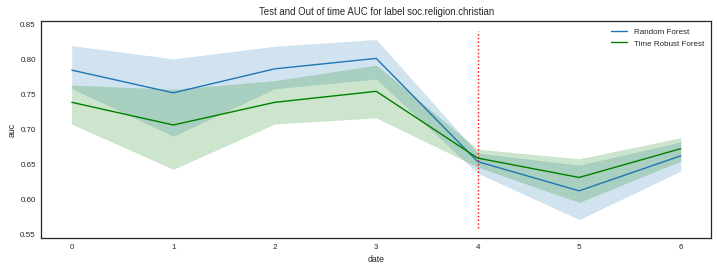

*****************************
target_label = sci.electronics


  0%|          | 0/5 [00:00<?, ?it/s]

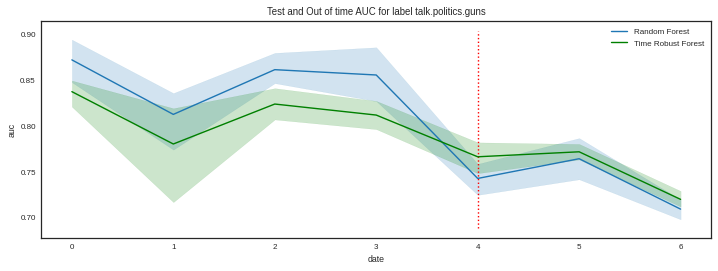

*****************************
target_label = talk.politics.guns


  0%|          | 0/5 [00:00<?, ?it/s]

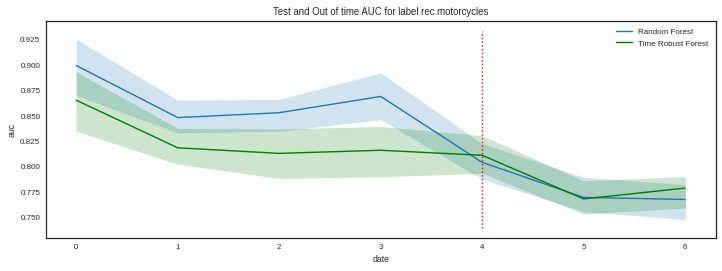

*****************************
target_label = sci.med


  0%|          | 0/5 [00:00<?, ?it/s]

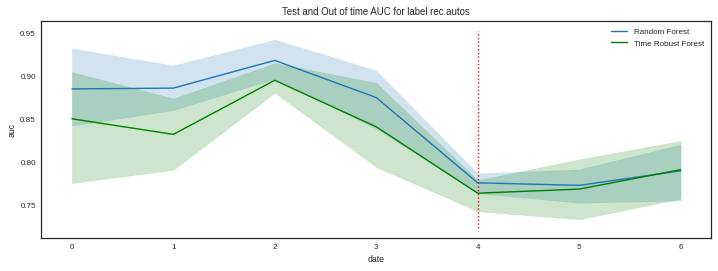

*****************************
target_label = comp.windows.x


  0%|          | 0/5 [00:00<?, ?it/s]

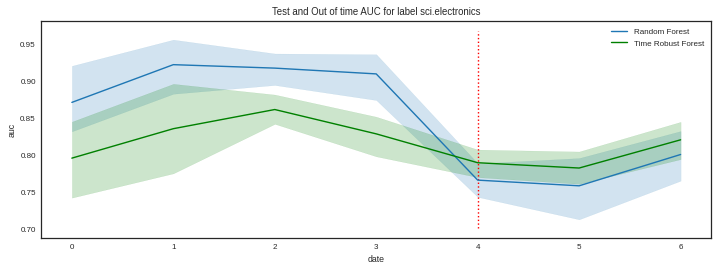

*****************************
target_label = misc.forsale


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
N_BOOTS = 5
train_aucs = []
test_aucs = []
out_of_time_aucs = []

challenger_all_labels_auc = []
benchmark_all_labels_auc = []
benchmark_all_labels_auc_opt = []

challenger_train_auc = []
bechmark_train_auc = []
bechmark_opt_train_auc = []


for i, target_label in enumerate(in_time["target"].unique()[:]):
    print("*****************************")
    print("target_label = {}".format(label_dict[target_label]))
    
    out_of_time["binary_target"] = out_of_time["target"].apply(lambda x: 1 if x == target_label else 0)
    in_time["binary_target"] = in_time["target"].apply(lambda x: 1 if x == target_label else 0)
    challenger_boot = []
    benchmark_boot = []
    benchmark_boot_opt = []    
    
    for n_boot in tqdm_notebook(range(N_BOOTS)):
        try:
            resampled_out_of_time = out_of_time.sample(frac=1.0, replace=True)
            train, test = train_test_split(in_time.sample(frac=1.0, replace=True), 
                                       test_size=0.2, 
                                       random_state=42)

            vectorizer = TfidfVectorizer(max_features=MAX_VOCABULARY,
                                 stop_words="english",
                                 binary=False,
                                 use_idf=True,
                                 norm=False)

            train_vectors = pd.DataFrame(vectorizer.fit_transform(train["data"]).toarray(), columns=vectorizer.vocabulary_)
            test_vectors = pd.DataFrame(vectorizer.transform(test["data"]).toarray(), columns=vectorizer.vocabulary_)
            oot_vectors = pd.DataFrame(vectorizer.transform(resampled_out_of_time["data"]).toarray(), columns=vectorizer.vocabulary_)

            train_vectors[time_column] = train[time_column].values
            test_vectors[time_column] = test[time_column].values
            oot_vectors[time_column] = resampled_out_of_time[time_column].values
            
            train_vectors[dummy_time_column] = 1
            features = list(vectorizer.vocabulary_.keys())
            
            ### Time Forest
            challenger_model = TimeForestClassifier(time_column=time_column,
                                           multi=True, 
                                           **challenger_opt_param_dict[label_dict[target_label]])
            challenger_model.fit(train_vectors[features + [time_column]], train[target])
            train["time_prediction_tree"] = challenger_model.predict_proba(train_vectors[features])[:, 1]
            train_auc = roc_auc_score(train[target], train["time_prediction_tree"])

            test["time_prediction_tree"] = challenger_model.predict_proba(test_vectors[features])[:, 1]
            test_auc = roc_auc_score(test[target], test["time_prediction_tree"])

            resampled_out_of_time["time_prediction_tree"] = challenger_model.predict_proba(oot_vectors[features])[:, 1]
            oot_auc = roc_auc_score(resampled_out_of_time[target], resampled_out_of_time["time_prediction_tree"])
            
            challenger_train_auc.append(train_auc)
            
            ### Benchmark
            model = TimeForestClassifier(time_column=dummy_time_column,
                                           multi=True, 
                                           **benchmark_opt_param_dict[label_dict[target_label]])
            
            model.fit(train_vectors[features + [dummy_time_column]], train[target])

            train["prediction"] = model.predict_proba(train_vectors[features])[:, 1]
            test["prediction"] = model.predict_proba(test_vectors[features])[:, 1]
            resampled_out_of_time["prediction"] = model.predict_proba(oot_vectors[features])[:, 1]

            benchmark_auc_by_date = pd.DataFrame(pd.concat([test, resampled_out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction"])), columns=["auc"]).reset_index()
            challenger_auc_by_date = pd.DataFrame(pd.concat([test, resampled_out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction_tree"])), columns=["auc"]).reset_index()

            challenger_boot.append(challenger_auc_by_date)
            benchmark_boot.append(benchmark_auc_by_date) 
            
            train_auc = roc_auc_score(train[target], train["prediction"])
            bechmark_train_auc.append(train_auc)
        except:
            print("Failed label {}".format(target_label))
    
    challenger_auc_by_target = pd.concat(challenger_boot)
    benchmark_auc_by_target = pd.concat(benchmark_boot)    
    
    challenger_all_labels_auc.append(challenger_auc_by_target)
    benchmark_all_labels_auc.append(benchmark_auc_by_target)    
    
    sns.lineplot(data=benchmark_auc_by_target.reset_index(), x="date", y="auc", label="Random Forest")
    sns.lineplot(data=challenger_auc_by_target.reset_index(), x="date", y="auc", label="Time Robust Forest", color="green")
    xmin, xmax, ymin, ymax = plt.axis()
    plt.vlines(out_of_time_min_date, ymin, ymax, linestyle="dotted", color="red", label="Time split")

    plt.title("Test and Out of time AUC for label {}".format(label_dict.get(i, i)))
    plt.show()
    

In [59]:
benchmark_auc_by_target.reset_index(inplace=True)
challenger_auc_by_target.reset_index(inplace=True)

In [60]:
print(np.mean(bechmark_train_auc))
print(np.mean(challenger_train_auc))

0.9392698803808618
0.8696011716274422


In [78]:
print(benchmark_auc_by_target[~challenger_auc_by_target["date"].isin([4, 5, 6])]["auc"].mean())
print(challenger_auc_by_target[~challenger_auc_by_target["date"].isin([4, 5, 6])]["auc"].mean())

0.8678500260884628
0.8284299983807513


In [79]:
print(benchmark_auc_by_target[challenger_auc_by_target["date"].isin([4, 5, 6])]["auc"].mean())
print(challenger_auc_by_target[challenger_auc_by_target["date"].isin([4, 5, 6])]["auc"].mean())

0.7682607168319857
0.7746665208501454


### Plot benchmark Vs challenger:

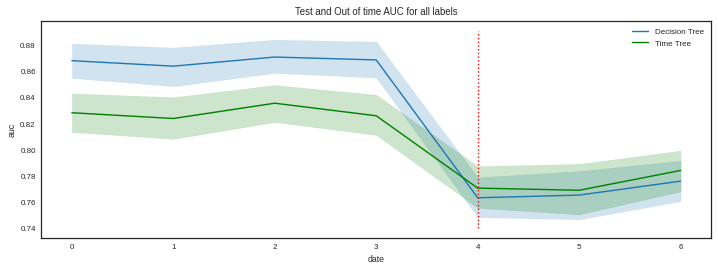

In [61]:
challenger_auc_by_target = pd.concat(challenger_all_labels_auc)
benchmark_auc_by_target = pd.concat(benchmark_all_labels_auc)  
benchmark_auc_by_target.reset_index(inplace=True)
challenger_auc_by_target.reset_index(inplace=True)
    

sns.lineplot(data=benchmark_auc_by_target, x="date", y="auc", label="Decision Tree")
sns.lineplot(data=challenger_auc_by_target, x="date", y="auc", label="Time Tree", color="green")
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(out_of_time_min_date, ymin, ymax, linestyle="dotted", color="red", label="Time split")

plt.title("Test and Out of time AUC for all labels")
plt.show()

In [62]:
from matplotlib.collections import PolyCollection as p

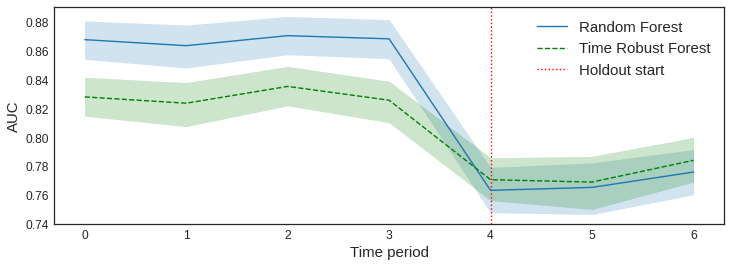

In [69]:
fig, ax = plt.subplots()
# challenger_auc_by_target = pd.concat(challenger_all_labels_auc)
# benchmark_auc_by_target = pd.concat(benchmark_all_labels_auc)  
    

sns.lineplot(data=benchmark_auc_by_target, x="date", y="auc", label="Random Forest")
sns.lineplot(data=challenger_auc_by_target, x="date", y="auc", label="Time Robust Forest", color="green", linestyle="dashed")
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(out_of_time_min_date, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")

#plt.title("Test and Out of time AUC for all labels")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Time period", fontsize=15)

__file__ = "../images/20news_same_capacity"
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

plt.savefig(__file__+".eps")
plt.savefig("../images/20news_aggregate.eps", format="eps", bbox_inches="tight")
plt.show()

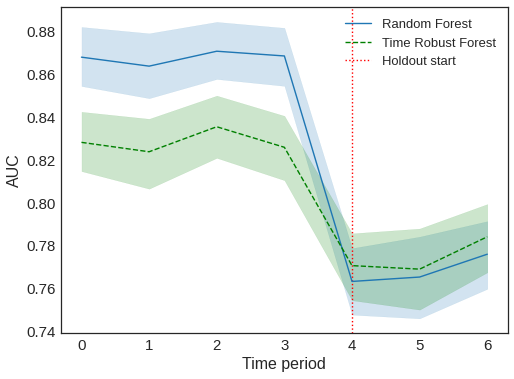

In [70]:
fig, ax = plt.subplots(figsize=(8, 6))
#benchmark_auc_by_target = pd.concat(benchmark_all_labels_auc)  

sns.lineplot(data=benchmark_auc_by_target, x="date", y="auc", label="Random Forest")
sns.lineplot(data=challenger_auc_by_target, x="date", y="auc", label="Time Robust Forest", color="green", linestyle="dashed")
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(out_of_time_min_date, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")

#plt.title("Test and Out of time AUC for all labels")

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

plt.ylim([ymin, ymax])
plt.legend(fontsize=13, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=16)
plt.xlabel("Time period", fontsize=16)

__file__ = "../images/20news_pycaret_aggregate_opt_square"
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

plt.savefig(__file__+".eps")
plt.savefig("../images/20news_pycaret_aggregate_opt_square.eps", format="eps")
plt.show()

In [65]:
# challenger_auc_by_target.to_csv("results/6_20newsgroups_example_challenger.csv")
# benchmark_auc_by_target.to_csv("results/6_20newsgroups_example_benchmark.csv")
# benchmark_auc_by_target_opt.to_csv("results/6_20newsgroups_example_benchmark_opt.csv")

Looking to the difference directly.

In [66]:
challenger_auc_by_target["diff"] = challenger_auc_by_target["auc"] - benchmark_auc_by_target["auc"]

In [67]:
challenger_auc_by_target

,level_0,date,auc,index,diff
0,0,0,0.775102,NaN,-0.007210
1,1,1,0.777525,NaN,-0.037622
2,2,2,0.725285,NaN,-0.014754
3,3,3,0.795026,NaN,-0.015198
4,4,4,0.680101,NaN,0.015997
...,...,...,...,...,...
485,30,2,0.832929,2.0,-0.051942
486,31,3,0.804838,3.0,-0.076751
487,32,4,0.787729,4.0,0.038192
488,33,5,0.832594,5.0,0.002337


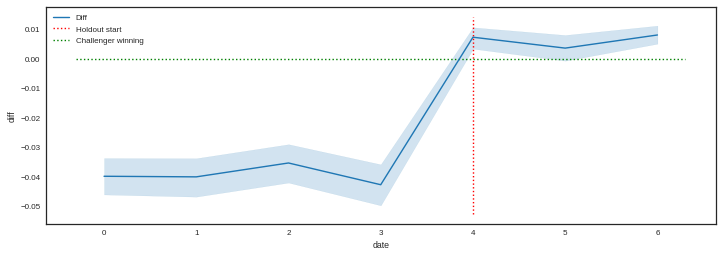

In [68]:
sns.lineplot(data=challenger_auc_by_target, x="date", y="diff", label="Diff")
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(out_of_time_min_date, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.hlines(0, xmin, xmax, linestyle="dotted", color="green", label="Challenger winning")
plt.legend()

### Domain Classifier

In [42]:
train_vectors["target"] = train["target"].values
test_vectors["target"] = test["target"].values
oot_vectors["target"] = out_of_time["target"].values

In [44]:
train_vectors["domain"] = 1
test_vectors["domain"] = 1
oot_vectors["domain"] = 0

In [45]:
domain_data = pd.concat([train_vectors, test_vectors, oot_vectors])

In [46]:
from pycaret.classification import *

In [51]:
domain_classifiers_auc = []
for i, target_label in enumerate(domain_data["target"].unique()[:]):
    print("*****************************")

    train_domain, test_domain = train_test_split(domain_data[domain_data["target"] == target_label], 
                                   test_size=0.2,
                                   random_state=42)
    
    clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=122, 
             log_experiment=False, 
             experiment_name="{}_domain_{}".format(PREFIX, target_label),
             silent=True)

    rf = create_model('rf')
    tuned_domain_rf = tune_model(rf,
                                 optimize="AUC",
                                 fold=5,
                                 n_iter=50)
    
    domain_model = tuned_domain_rf
    domain_model.fit(train_domain[features], train_domain["domain"])
    test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]
    domain_auc = roc_auc_score(test_domain["domain"], test_domain["pred_domain"])
    print(domain_auc)
    domain_classifiers_auc.append(domain_auc)
    

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5225,0.5758,0.5303,0.6140,0.5691,0.0401,0.0407
1,0.5495,0.5513,0.6818,0.6081,0.6429,0.0385,0.0389
2,0.5225,0.5268,0.6462,0.5833,0.6131,-0.0062,-0.0062
3,0.5045,0.4622,0.6769,0.5641,0.6154,-0.0649,-0.0670
4,0.6182,0.6294,0.7692,0.6494,0.7042,0.1765,0.1816
Mean,0.5435,0.5491,0.6609,0.6038,0.6289,0.0368,0.0376
SD,0.0400,0.0552,0.0771,0.0290,0.0444,0.0796,0.0820


0.6416587527698638


In [52]:
np.mean(domain_classifiers_auc)

0.6320037548651734

In [53]:
np.median(domain_classifiers_auc)

0.6306870414227472